In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from tensorflow.keras import layers, models, optimizers, losses
import keras_nlp as nlp 
import tensorflow as tf

from matplotlib import pyplot as plt
from dataclasses import dataclass 
from typing import *
import pandas as pd
import numpy as np

2024-09-12 14:15:03.529275: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 14:15:03.529445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 14:15:03.775672: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
filenames = [

    "/kaggle/input/clear-hack/overall_80K_corrected.csv"
]

def read_file(filename):
    df   = pd.read_csv(filename)
    cols = [col for col in df.columns if col.lower().__contains__("source") or col.lower().__contains__("target")]
    df   = df[list(sorted(cols))]
    df.columns   = ["RUS", "MAN"]
    return df

train = pd.concat(list(map(read_file, filenames)), axis=0)
train.head()

,RUS,MAN
0,Те мальчики не выполнят задание в назначенный ...,Та пыгрисит маим вармаль э̄рнэ поратэт ат верм...
1,"Бегая к берегу озера пришла, к воде подбежала.","Ха̄йтыматэ тӯр ва̄тан ёхтыс, вит ва̄тан ха̄йтыс."
2,Вода прибывала на глазах,Вит са̄мыл сунсым о̄нтыс
3,"Обнюхивает нас, живыми на кладбище уносит.","Атаявев, акваг лылынг тагл ворн та тотавев."
4,Мы никогда не забудем этого честного человека.,"Ман ты пӣлтал, веськат хумиюв нэтхуньт ат ёр..."


In [3]:
print(f"dataset size: {len(train):,}")

dataset size: 79,958


In [4]:
def create_vocabulary(texts:List[str], vocab_size:int=5_000, lowercase:bool=False, output_file:Optional[str]=None, 
                      reserved_tokens:List[str]=['<pad>', '<s>', '</s>', '<unk>', '<mask>']):
    return nlp.tokenizers.compute_word_piece_vocabulary(
            tf.data.Dataset.from_tensor_slices(texts).batch(1_000),
            vocabulary_size=vocab_size,
            vocabulary_output_file=output_file,
            lowercase=lowercase,
            reserved_tokens=reserved_tokens
    )

In [8]:
@dataclass
class VocabularyConfig:
    man_max_vocab_size: int = 2_000 
    rus_max_vocab_size: int = 3_000 
    
    man_vocab_file: str = None 
    rus_vocab_file: str = None
        
    lower: bool = False 
    seq_len:int = 128
        
    start_token:str = "<s>"
    end_token:str   = "</s>"
    pad_token:str   = "<pad>"
    unk_token:str   = "<unk>"
    mask_token:str  = "<mask>"

In [14]:
man_vocab = create_vocabulary(
    list(train["MAN"]), VocabularyConfig.man_max_vocab_size,lowercase=VocabularyConfig.lower,
    output_file=VocabularyConfig.man_vocab_file,reserved_tokens=[
        VocabularyConfig.start_token,
        VocabularyConfig.end_token,
        VocabularyConfig.pad_token,
        VocabularyConfig.unk_token,
        VocabularyConfig.mask_token
    ]
)

rus_vocab = create_vocabulary(
   list(train["RUS"]), VocabularyConfig.rus_max_vocab_size,lowercase=VocabularyConfig.lower,
    output_file=VocabularyConfig.rus_vocab_file, reserved_tokens=[
        VocabularyConfig.start_token,
        VocabularyConfig.end_token,
        VocabularyConfig.pad_token,
        VocabularyConfig.unk_token,
        VocabularyConfig.mask_token
    ]
)

In [15]:
man_tokenizer = nlp.tokenizers.WordPieceTokenizer(
    vocabulary=man_vocab, oov_token=VocabularyConfig.unk_token, lowercase=VocabularyConfig.lower
)
rus_tokenizer = nlp.tokenizers.WordPieceTokenizer(
    vocabulary=rus_vocab, oov_token=VocabularyConfig.unk_token, lowercase=VocabularyConfig.lower
)
man_packer = nlp.layers.StartEndPacker(
    VocabularyConfig.seq_len+1, 
    start_value=man_tokenizer.token_to_id(VocabularyConfig.start_token),
    end_value=man_tokenizer.token_to_id(VocabularyConfig.end_token),
    pad_value=man_tokenizer.token_to_id(VocabularyConfig.pad_token),
    return_padding_mask=False
)

rus_packer = nlp.layers.StartEndPacker(
    VocabularyConfig.seq_len, 
    start_value=rus_tokenizer.token_to_id(VocabularyConfig.start_token),
    end_value=rus_tokenizer.token_to_id(VocabularyConfig.end_token),
    pad_value=rus_tokenizer.token_to_id(VocabularyConfig.pad_token),
    return_padding_mask=True
)

In [18]:
for idx, row in train.sample(8).iterrows():
    man_token = man_tokenizer(row.MAN)
    rus_token = rus_tokenizer(row.RUS)
    print(f"""
    man  📃 : {row.MAN}
    MAN Token  : {man_token}
    RC Token  : {man_tokenizer.detokenize(man_token).numpy().decode("utf-8")} 
    {150*"-"}
    RUS 📜 : {row.RUS}
    RUS Token  : {rus_token}
    RC Token  : {rus_tokenizer.detokenize(rus_token).numpy().decode("utf-8")}
    {150*"_"}
    """)


    man  📃 : Колпо̄х ма̄хманэ тавēн ла̄вēгыт.
    MAN Token  : [1150  283  796  273 1414  913  147 1423 1769   16]
    RC Token  : Колпо̄х ма̄хманэ тавēн ла̄вēгыт . 
    ------------------------------------------------------------------------------------------------------------------------------------------------------
    RUS 📜 : Соседки советуют ей.
    RUS Token  : [1189 1625 1487  332 1409 2090  541   18]
    RC Token  : Соседки советуют ей .
    ______________________________________________________________________________________________________________________________________________________
    

    man  📃 : Тав официально ат артамын тэлатэ сутыт сунсыглавес.
    MAN Token  : [ 216  150 1912  223 1913  223  846 1293  203  136  768  420  210  154
  215  636  229  153  661  202  681  244  876   16]
    RC Token  : Тав официально ат артамын тэлатэ сутыт сунсыглавес . 
    ------------------------------------------------------------------------------------------------------------

In [25]:
def prepare_batch(rus:tf.Tensor, man:tf.Tensor)->Union[Dict[str, tf.Tensor], tf.Tensor]:
    rus = rus_tokenizer(rus)
    rus, pad_mask  = rus_packer(rus)
    pad_mask = tf.cast(pad_mask, tf.int32)
    
    man = man_tokenizer(man)
    man = man_packer(man)
    return (
        {
            "encoder_inputs": rus,
            "attention_mask": pad_mask,
            "decoder_inputs": man[:, :-1]
        }, 
            man[:, 1:]
       ) 

def prepare_batch_hf(rus:tf.Tensor, man:tf.Tensor)->Union[Dict[str, tf.Tensor], tf.Tensor]:
    rus = rus_tokenizer(rus)
    rus, pad_mask  = rus_packer(rus)
    pad_mask = tf.cast(pad_mask, tf.int32)
    
    man = man_tokenizer(man)
    man = man_packer(man)
    return (
        {
            "input_ids": rus,
            "attention_mask": pad_mask,
            "decoder_inputs": man[:, :-1]
        }, 
            man[:, 1:]
       ) 

In [26]:
def create_dataset(dataframe:pd.DataFrame, batch:int, shuffle:bool=False, repeat:bool=False, cache:bool=False, cache_dir="",
                   mode:Literal[None, "hf"]=None, is_train:bool=False):
    
    dataframe = dataframe.copy()
    auto = tf.data.AUTOTUNE
    
    ds = (
        tf.data.Dataset.from_tensor_slices((dataframe["RUS"], dataframe["MAN"]))
        .batch(batch)
        .map(prepare_batch if mode is None else prepare_batch_hf, auto)
    )
    ds = ds.repeat() if repeat else ds
    ds = ds.shuffle(5_000) if shuffle and is_train else ds
    if cache_dir:
        os.makedirs(cache_dir, exist_ok=True)
        
    ds = ds.cache(cache_dir) if cache else ds
    
    return ds.prefetch(auto)

In [27]:
ds = create_dataset(train, 16)

In [28]:
for inputs, labels in ds.unbatch().take(10):
    rus = inputs['encoder_inputs']
    mask   = inputs['attention_mask']
    rus = tf.boolean_mask(rus, mask)
    man  = inputs["decoder_inputs"]
    mask   = man!= man_tokenizer.token_to_id(VocabularyConfig.pad_token)
    man  = tf.boolean_mask(man, mask)
    
    mask   = labels!= man_tokenizer.token_to_id(VocabularyConfig.pad_token)
    labels  = tf.boolean_mask(labels, mask)
    print(f"Encoder Inputs 📃: {rus_tokenizer.detokenize(rus).numpy().decode('utf-8')}")
    print(f"Decoder Inputs 📜: {man_tokenizer.detokenize(man).numpy().decode('utf-8')}")
    print(150*"-")
    print(f"Label   Inputs 📋: {man_tokenizer.detokenize(labels).numpy().decode('utf-8')}")
    print(150*"_")

Encoder Inputs 📃: <s> Те мальчики не выполнят задание в назначенный срок . </s>
Decoder Inputs 📜: <s> Та пыгрисит маим вармаль э̄рнэ поратэт ат вермгыг варункв </s>
------------------------------------------------------------------------------------------------------------------------------------------------------
Label   Inputs 📋: Та пыгрисит маим вармаль э̄рнэ поратэт ат вермгыг варункв </s>
______________________________________________________________________________________________________________________________________________________
Encoder Inputs 📃: <s> Бегая к берегу озера пришла , к воде подбежала . </s>
Decoder Inputs 📜: <s> Ха̄йтыматэ тӯр ва̄тан ёхтыс , вит ва̄тан ха̄йтыс . </s>
------------------------------------------------------------------------------------------------------------------------------------------------------
Label   Inputs 📋: Ха̄йтыматэ тӯр ва̄тан ёхтыс , вит ва̄тан ха̄йтыс . </s>
_________________________________________________________________________

In [29]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, vocab_size, model_dim, seq_len=512, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.model_dim  = model_dim
        
        self._pos = np.zeros((seq_len, model_dim), dtype="float32")
        for i in range(seq_len):
            for j in range(0, self.model_dim, 2):
                self._pos[i,   j] = np.sin(i / (10000 ** ((2 * j)/self.model_dim)))
                self._pos[i, j+1] = np.cos(i / (10000 ** ((2 * (j + 1))/self.model_dim)))
                
        self._pos = tf.constant(self._pos, shape=[1, seq_len, self.model_dim], dtype="float32")
        
        
    def build(self, input_shape):
        self._embedding = layers.Embedding(self.vocab_size, self.model_dim)
        self._embedding.build(input_shape)
        return super().build(input_shape)
    
    def call(self, inputs, **kwargs):
        shape = tf.shape(inputs)
        x  = self._embedding(inputs, **kwargs)
        x += tf.tile(self._pos[:, :shape[1], :], [shape[0], 1, 1])
        x *= tf.sqrt(tf.cast(self.model_dim, inputs.dtype))
        return x

In [30]:
class FeedForward(layers.Layer):
    def __init__(self, model_dim, hidden_dim=1024, activation="gelu", dropout=0.05, epsilon=1e-4, **kwargs):
        super().__init__(**kwargs)
        self.model_dim  = model_dim
        self.hidden_dim = hidden_dim
        self.dropout    = dropout
        self.activation = activation
        self.epsilon    = epsilon
    
    def build(self, input_shape):
        self._mlp = models.Sequential([
            layers.Dense(self.hidden_dim, activation=self.activation, name=f"{self.name}_dense1"),
            layers.Dropout(self.dropout, name=f"{self.name}_dropout"),
            layers.Dense(self.model_dim, name=f"{self.name}_dense2")
        ])
        self._mlp_ln = layers.LayerNormalization(epsilon=self.epsilon, name=f"{self.name}_ln")
        self._mlp_ln.build(input_shape)
        return super().build(input_shape)
    
    def call(self, inputs, **kwargs):
        return self._mlp(self._mlp_ln(inputs, **kwargs), **kwargs)

In [31]:
class GlobalSelfAttention(layers.Layer):
    def __init__(self, model_dim, num_heads, key_dim=None, dropout=0.05, epsilon=1e-4, **kwargs):
        super().__init__(**kwargs)
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.epsilon   = epsilon
        self.dropout   = dropout
        self.key_dim   = model_dim//num_heads if key_dim is None else key_dim
        
    def build(self, input_shape):
        self._attn    = layers.MultiHeadAttention(self.num_heads, self.key_dim, dropout=self.dropout, name=f"{self.name}_attn")
        self._attn_ln = layers.LayerNormalization(epsilon=self.epsilon, name=f"{self.name}_attn_ln")
        self._attn.build(input_shape, input_shape)
        self._attn_ln.build(input_shape)
        return super().build(input_shape)
    
    def call(self, inputs, attention_mask=None, **kwargs):
        if not attention_mask is None:
            attention_mask = tf.expand_dims(attention_mask, axis=-1)
        inputs = self._attn_ln(inputs, **kwargs)
        return inputs + self._attn(inputs, inputs, **kwargs, attention_mask=attention_mask)

In [32]:
class CausalAttention(layers.Layer):
    def __init__(self, model_dim, num_heads, key_dim=None, dropout=0.05, epsilon=1e-4, **kwargs):
        super().__init__(**kwargs)
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.epsilon   = epsilon
        self.dropout   = dropout
        self.key_dim   = model_dim//num_heads if key_dim is None else key_dim
        
    def build(self, input_shape):
        self._attn    = layers.MultiHeadAttention(self.num_heads, self.key_dim, dropout=self.dropout, name=f"{self.name}_attn")
        self._attn_ln = layers.LayerNormalization(epsilon=self.epsilon, name=f"{self.name}_attn_ln")
        self._attn.build(input_shape, input_shape)
        self._attn_ln.build(input_shape)
        return super().build(input_shape)
    
    def call(self, inputs, attention_mask=None, **kwargs):
        inputs = self._attn_ln(inputs, **kwargs)
        return inputs + self._attn(inputs, inputs, **kwargs, use_causal_mask=True)

In [33]:
class CrossAttention(layers.Layer):
    def __init__(self, model_dim, num_heads, key_dim=None, dropout=0.05, epsilon=1e-4, **kwargs):
        super().__init__(**kwargs)
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.epsilon   = epsilon
        self.dropout   = dropout
        self.key_dim   = model_dim//num_heads if key_dim is None else key_dim
        
    def build(self, input_shape):
        self._attn    = layers.MultiHeadAttention(self.num_heads, self.key_dim, dropout=self.dropout, name=f"{self.name}_attn")
        self._attn_ln = layers.LayerNormalization(epsilon=self.epsilon, name=f"{self.name}_attn_ln")
        self._attn.build(*input_shape)
        self._attn_ln.build(input_shape[0])
        return super().build(input_shape)
    
    def call(self, inputs, **kwargs):
        inputs, context = inputs
        inputs = self._attn_ln(inputs, **kwargs)
        return inputs + self._attn(inputs, context, **kwargs)

In [34]:
class EncoderLayer(layers.Layer):
    def __init__(self, model_dim, num_heads=6, key_dim=None, dropout=0.0, activation="relu", hidden_dim=1024, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.model_dim  = model_dim
        self.num_heads  = num_heads
        self.key_dim    = key_dim
        self.hidden_dim = hidden_dim
        self.epsilon    = epsilon
        self.activation = activation
        self.dropout    = dropout
    
    def build(self, input_shape):
        self._attn = GlobalSelfAttention(self.model_dim, self.num_heads, self.key_dim, self.dropout, self.epsilon, 
                                        name=f"{self.name}_attn")
        self._mlp  = FeedForward(self.model_dim, self.hidden_dim, self.activation, self.epsilon, name=f"{self.name}_mlp")
        self._attn.build(input_shape)
        self._mlp.build(input_shape)
        return super().build(input_shape)
    
    def call(self, inputs, attention_mask=None, **kwargs):
        return self._mlp(self._attn(inputs, attention_mask=attention_mask, **kwargs), **kwargs)

In [35]:
class DecoderLayer(layers.Layer):
    def __init__(self, model_dim, num_heads=6, key_dim=None, dropout=0.0, activation="relu", hidden_dim=1024, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.model_dim  = model_dim
        self.num_heads  = num_heads
        self.key_dim    = key_dim
        self.hidden_dim = hidden_dim
        self.epsilon    = epsilon
        self.activation = activation
        self.dropout    = dropout
    
    def build(self, input_shape):
        self._attn = CausalAttention(
            self.model_dim, self.num_heads, self.key_dim, self.dropout, self.epsilon, name=f"{self.name}_attn"
        )
        self._cross_attn = CrossAttention(
            self.model_dim, self.num_heads, self.key_dim, self.dropout, self.epsilon, name=f"{self.name}_cross_attn"
        )
        self._mlp  = FeedForward(self.model_dim, self.hidden_dim, self.activation, self.epsilon, name=f"{self.name}_mlp")
        self._attn.build(input_shape[0])
        self._cross_attn.build(input_shape)
        self._mlp.build(input_shape[0])
        return super().build(input_shape)
    
    def call(self, inputs, **kwargs):
        inputs, context = inputs
        inputs = self._attn(inputs, **kwargs)
        inputs = self._cross_attn((inputs, context), **kwargs)
        inputs = self._mlp(inputs, **kwargs)
        return inputs

In [36]:
def masked_loss(label, pred):
    mask = label != man_tokenizer.token_to_id(VocabularyConfig.pad_token)
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred
    mask = label != rus_tokenizer.token_to_id(VocabularyConfig.pad_token)
    match = match & mask
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [39]:
def create_model(model_dim, num_heads=4, num_layers=4, key_dim=None, activation="relu", dropout=0.0, hidden_dim=1024):
    encoder_inputs = layers.Input(shape=(None,), name="encoder_inputs")
    attention_mask = layers.Input(shape=(None,), name="attention_mask")
    decoder_inputs = layers.Input(shape=(None,), name="decoder_inputs")
    
    inputs = {
            "encoder_inputs": encoder_inputs,
            "attention_mask": attention_mask,
            "decoder_inputs": decoder_inputs
        }
    
    encoder_inputs = PositionalEmbedding(rus_tokenizer.vocabulary_size(), model_dim, name="fr_positional_emb")(encoder_inputs)
    decoder_inputs = PositionalEmbedding(man_tokenizer.vocabulary_size(), model_dim, name="wl_positional_emb")(decoder_inputs)
    
    for i in range(1, num_layers+1):
        encoder_inputs = EncoderLayer(model_dim, num_heads, key_dim, dropout, activation, hidden_dim, name=f"EncoderLayer_{i}")(
            encoder_inputs, attention_mask
        )
    
    
    for i in range(1, num_layers+1):
        decoder_inputs = DecoderLayer(model_dim, num_heads, key_dim, dropout, activation, hidden_dim, name=f"DecoderLayer_{i}")(
            (decoder_inputs, encoder_inputs),
        )
    
    outputs = layers.Dense(man_tokenizer.vocabulary_size(), name="prediction", bias_initializer="zeros")(decoder_inputs)
    
    model = models.Model(inputs, outputs, name="Transformer")
    
    model.compile(
        loss = masked_loss,
        optimizer = optimizers.Adam(learning_rate=1e-3),
        metrics = [masked_accuracy]
    )
    
    return model

In [40]:
tf.keras.backend.clear_session()
model_dim  = 256
num_layers = 2
hidden_dim = 4*model_dim
dropout    = 0.2
num_heads  = 2

model = create_model(
    model_dim=model_dim, num_heads=num_heads, num_layers=num_layers, hidden_dim=hidden_dim, dropout=dropout, activation="gelu"
)

In [41]:
model.summary()

Model: "Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fr_positional_emb   │ (None, None, 256) │    750,592 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EncoderLayer_1      │ (None, None, 256) │    789,760 │ fr_positional_em… │
│ (EncoderLayer)      │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wl_positional_emb   │ (None, None, 256) │    498,176 │ decoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EncoderLayer_2      │ (None, None, 256) │    789,760 │ EncoderLayer_1[0… │
│ (EncoderLayer)      │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecoderLayer_1      │ (None, None, 256) │  1,053,440 │ wl_positional_em… │
│ (DecoderLayer)      │                   │            │ EncoderLayer_2[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DecoderLayer_2      │ (None, None, 256) │  1,053,440 │ DecoderLayer_1[0… │
│ (DecoderLayer)      │                   │            │ EncoderLayer_2[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction (Dense)  │ (None, None,      │    500,122 │ DecoderLayer_2[0… │
│                     │ 1946)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,435,290 (20.73 MB)

 Trainable params: 5,435,290 (20.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, dpi=80, show_layer_activations=True, show_trainable=True)

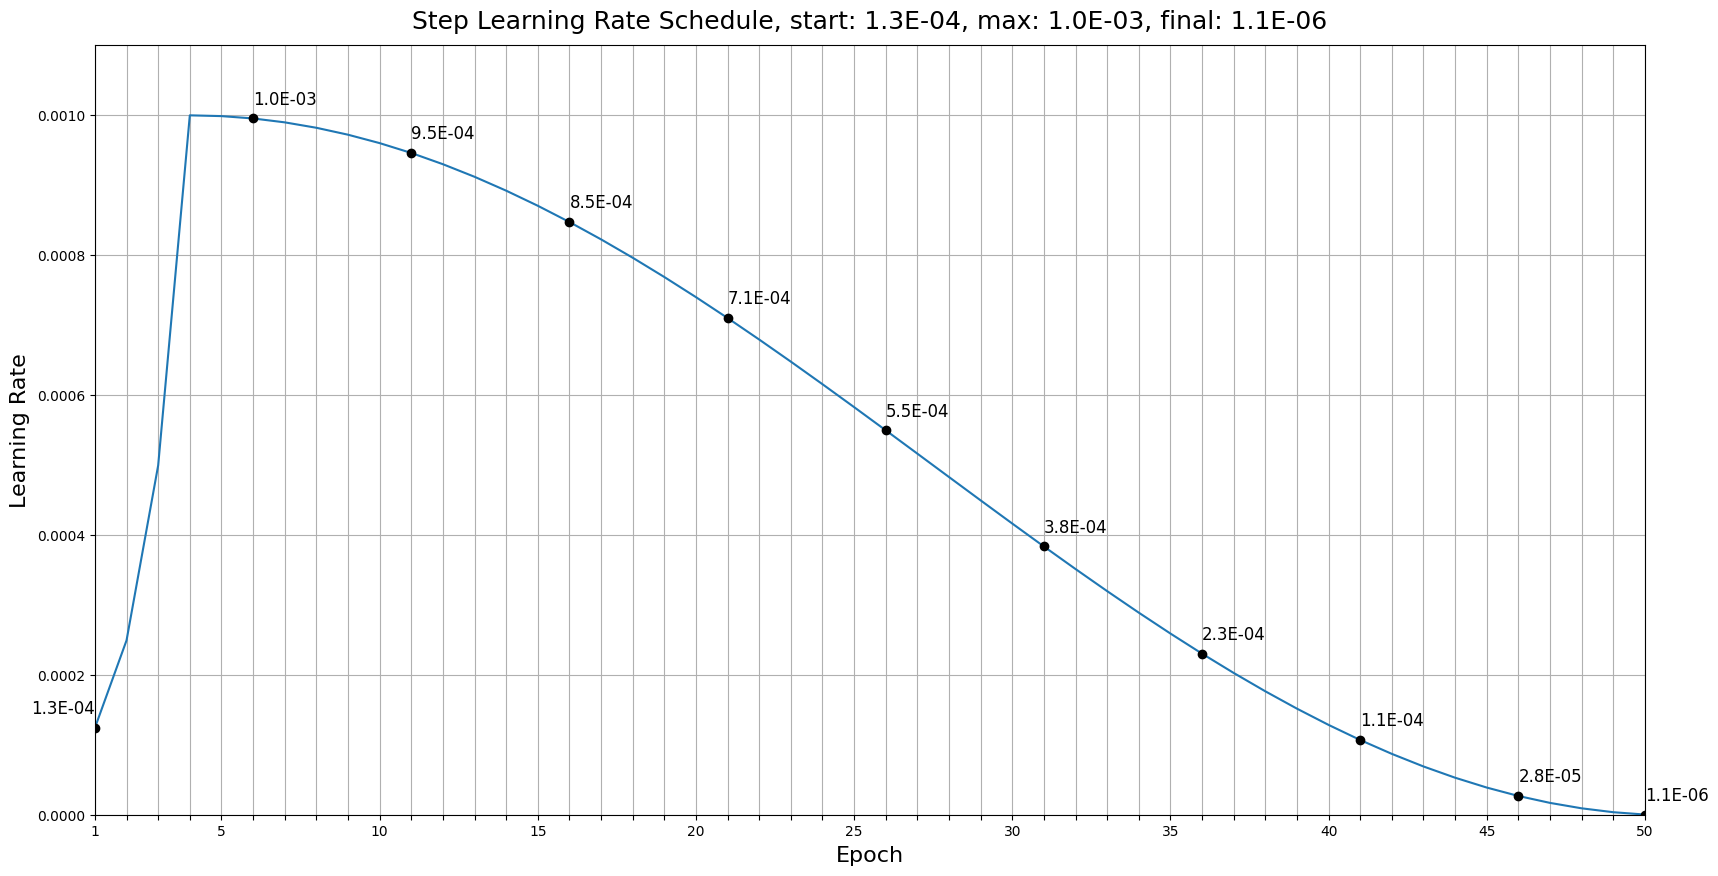

In [43]:
N_EPOCHS         = 50
BATCH            = 256
N_WARMUP_EPOCHS  = 3
LR_MAX           = 0.001
WD_RATIO         = 0.05
WARMUP_METHOD    = "cos"
TEST_SIZE        = 0.25
RANDOM_STATE     = 1
MODEL_CHECKPOINT = "Transformer.weights.h5"
VERBOSE          = 1


import math
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max


def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1

    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])

    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]

# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=VERBOSE)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_CHECKPOINT, verbose=VERBOSE, save_weights_only=True, save_best_only=True, monitor="val_masked_accuracy", 
    mode="max"
)
callbacks = [lr_callback, model_checkpoint]
from sklearn.model_selection import train_test_split

train_ds, valid_ds = train_test_split(train, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_ds = create_dataset(train_ds, BATCH, shuffle=True,  is_train=True)
valid_ds = create_dataset(valid_ds, BATCH, shuffle=False, is_train=False)

In [ ]:
model.fit(train_ds, epochs=N_EPOCHS, validation_data=valid_ds, callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.000125.
Epoch 1/50
 12/235 ━━━━━━━━━━━━━━━━━━━━ 1:13:45 20s/step - loss: 7.3815 - masked_accuracy: 0.0301

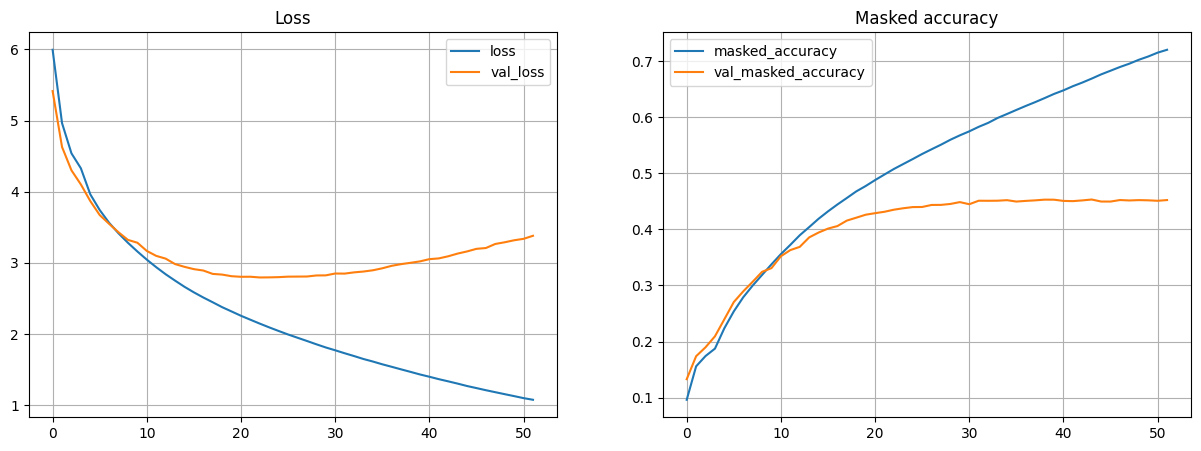

In [26]:
history = model.history.history

fig = plt.figure(figsize=(15, 5), dpi=100)

ax = fig.add_subplot(1, 2, 1)
ax.set_title("Loss")
ax.plot(history['loss'], label="loss")
ax.plot(history['val_loss'], label="val_loss")
plt.legend()
plt.grid()
ax = fig.add_subplot(1, 2, 2)
ax.set_title("Masked accuracy")
ax.plot(history['masked_accuracy'], label="masked_accuracy")
ax.plot(history['val_masked_accuracy'], label="val_masked_accuracy")
plt.legend()
plt.grid()
plt.show()

In [27]:
def generate_sequence(model, inputs, max_length=256):
    batch = tf.shape(inputs["encoder_inputs"])[0]
    assert batch == 1, "Batch must be 1"
    
    def generate_one_step(inputs, state):
        inputs["decoder_inputs"] = state
        state = model(inputs, training=False)
        state = state[:, -1:, :]
        state = tf.argmax(state, axis=-1, output_type=tf.int32)
        return state
    
    state = tf.constant(man_tokenizer.token_to_id("<s>"), shape=(1, 1), dtype="int32")
    state = tf.tile(state, [batch, 1])
    
    for _ in range(max_length-1):
        next_state = generate_one_step(inputs, state=state)
        state = tf.concat([state, next_state], axis=-1)
        if tf.reduce_any(state==man_tokenizer.token_to_id("</s>")): break
            
    return state

In [28]:
bleu_1 = nlp.metrics.Bleu(tokenizer=man_tokenizer, max_order=1)
bleu_2 = nlp.metrics.Bleu(tokenizer=man_tokenizer, max_order=4)

for inputs, labels in valid_ds.unbatch().batch(1).take(128):
    rus = inputs['encoder_inputs'][0]
    mask   = inputs['attention_mask'][0]
    man = tf.boolean_mask(french, mask)
    man  = inputs["decoder_inputs"][0]
    mask   = man != man_tokenizer.token_to_id(VocabularyConfig.pad_token)
    man  = tf.boolean_mask(man, mask)
    
    mask   = labels != man_tokenizer.token_to_id(VocabularyConfig.pad_token)
    labels = tf.boolean_mask(labels, mask)
    _ = inputs.pop("decoder_inputs")
    preds   = generate_sequence(model, inputs, max_length=384)
    label_man = man_tokenizer.detokenize(labels).numpy().decode('utf-8').replace('<s>', '').replace('</s>','').strip()
    preds_man = man_tokenizer.detokenize(preds[0]).numpy().decode('utf-8').replace('<s>', '').replace('</s>','').strip()
    print(f"Inputs 📃: {fr_tokenizer.detokenize(french).numpy().decode('utf-8').replace('<s>', '').replace('</s>','').strip()}")
    print(150*"-")
    print(f"Label 🧐: {label_man}")
    print(f"Preds 🤖: {preds_man}")
    print("\n")
    print(150*"_")
    
    bleu_1([label_man], [preds_man])
    bleu_2([label_man], [preds_man])

print("\n")
print("Bleu score max order 1", tf.stop_gradient(bleu_1.result()).numpy())
print("Bleu score max order 2", tf.stop_gradient(bleu_2.result()).numpy())

Inputs 📃: Он присел , мужчина говорит ему : " Сходи и жену сюда приведи " .
------------------------------------------------------------------------------------------------------------------------------------------------------
Label 🧐: Тув ёл - ӯнтыс , о̄йка тав нупылэ ла̄ви : " Ялэн , э̄кван о̄с тыг тотэ̄лн " .
Preds 🤖: Тав по̄хат ойка хо̄нтастэ , ла̄ви : " Ялэн ос тыг ёхтэ̄лын " .


______________________________________________________________________________________________________________________________________________________
Inputs 📃: Он так рассказывал : - Я в деревне Анеево 1961 года родился
------------------------------------------------------------------------------------------------------------------------------------------------------
Label 🧐: Тав тох ты потыртас : - Ам А̄нъя па̄вылт 1961 та̄лт самын патсум
Preds 🤖: Тав тох потыртас : – Ам ты Америкат самын патсум .


________________________________________________________________________________________________________